In [1]:
"""


Original paper - https://arxiv.org/abs/1611.08024



"""

'\n\n\nOriginal paper - https://arxiv.org/abs/1611.08024\n\n\n\n'

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Load in Hospital Data

In [2]:
import pickle

dir = "E:/ChristianMusaeus/Data/Eyes_closed_marked"
# with open(f"{dir}/df_EOandEC_norm.pkl", "rb") as f:
#     data = pickle.load(f)

# load df_EOandEC_norm.csv
data = pd.read_csv(f"{dir}/df_EOandEC_norm.csv")


print(data.shape)


epochs = data.iloc[:, :-2].values
labels = data.iloc[:, -2].values
patient_ids = data.iloc[:, -1].values


(3215, 3802)


# EEGNet 8,2 from paper


In [34]:
class EEGNetModel(nn.Module):  # EEGNET-8,2
    def __init__(self, chans=19, classes=1, time_points=200, temp_kernel=100,
                 f1=8, f2=16, d=2, pk1=4, pk2=4, dropout_rate=0.1, max_norm1=1, max_norm2=0.25):
        super(EEGNetModel, self).__init__()


        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),  # Temporal Conv
            nn.BatchNorm2d(f1),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False),  # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),  # Pool over time dimension
            nn.Dropout(dropout_rate)
        )
        # Separable Convolution
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16), padding='same', bias=False, groups=f2),  # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False),  # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),  # Pool over time dimension
            nn.Dropout(dropout_rate)
        )
        

        # Fully Connected
        self.fc = nn.Linear(16 * ( time_points // 16 ), classes)

    #     # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        # Input x is (batch_size,1, num_channels, num_timepoints)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # x = torch.sigmoid(x)
        return x


# Adjust input size to (19x200)
sample_len = 200  # Your time points
channels = 19     # Your number of channels

# summary
from torchsummary import summary
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# check if CUDA is available
print(device)
torch.cuda.is_available()
torch.cuda.get_device_name(0)

model = EEGNetModel(chans=channels, time_points=sample_len).to(device)
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)
# summary(model, (1, 19, 200))


print(model.forward(torch.rand(13, 1, channels, sample_len).to(device)))
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

cuda
tensor([[-0.9907],
        [-0.6325],
        [ 0.3910],
        [ 0.5514],
        [-0.1987],
        [ 0.3428],
        [-0.1400],
        [ 0.4497],
        [-0.7113],
        [-0.2275],
        [-0.2327],
        [-0.4286],
        [ 0.0461]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [4]:
import numpy as np
print(np.__version__)


1.23.5


# Dataset Class

In [6]:
from torch.utils.data import DataLoader, Dataset

# Dataset class definition
class EEGDataset(Dataset):
    def __init__(self, epochs, labels):
        self.df = epochs
        self.labels = labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Access the epoch and corresponding label
        data = self.df[idx]  # data shape: (3800)
        data = data.reshape(19,200)  # shape: (19, 200)
        label = self.labels[idx]  # label shape: (1)
        
        # Ensure the data is converted to float tensor
        data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
        
        # Convert label to tensor (assumed to be scalar)
        label_tensor = torch.tensor(label, dtype=torch.float32).to(device)
        
        return data_tensor, label_tensor

# Create EEGDataset object and print a batch of 13 samples
dataset = EEGDataset(epochs, labels)
dataloader = DataLoader(dataset, batch_size=13, shuffle=True)

print(next(iter(dataloader))[0].shape)



torch.Size([13, 19, 200])


# Training and evaluation loop

In [43]:
from sklearn.model_selection import LeaveOneGroupOut
from tqdm import tqdm
import torch
import numpy as np

# define random seed
torch.manual_seed(13)

batch_size = 128
num_epochs = 50
patience = 20  # Stop if no improvement after 20 epochs
best_val_acc = 0.0  # Track the best validation accuracy
no_improvement_epochs = 0  # Track how many epochs without improvement

# Lists to store loss values for plotting later
train_loss_history = []
val_loss_history = []

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

model = EEGNetModel().to(device)

# patient_ids = np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], len(epochs) // 10)  # Adjust the length accordingly
patient_ids = patient_ids

for epoch in tqdm(range(num_epochs)):  # Loop over the number of epochs
    print(f"Epoch {epoch+1}")
    running_loss = []
    running_val_loss = []

    for train_index, test_index in logo.split(epochs, labels, groups=patient_ids):
        

        # Train and test split
        X_train, X_val = epochs[train_index, :], epochs[test_index, :]
        y_train, y_val = labels[train_index], labels[test_index]
        
        # Create DataLoader for training and testing
        train_dataset = EEGDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = EEGDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Training
        model.train()
        for i, data in enumerate(train_loader, 0):
            # Get the inputs; data is a list of [inputs, labels/targets]
            inputs, targets = data

            inputs, targets = inputs.to(device), targets.to(device)


            
            # check if the input shape is correct
            inputs = inputs.unsqueeze(1)  # Add a channel dimension if needed
            # print(f"input shape: {inputs.shape}")

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            targets = targets.unsqueeze(1)  # Ensure targets have the same shape as outputs
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to prevent exploding gradients
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    print(f"{name}: Grad Mean = {param.grad.mean()}, Grad Std = {param.grad.std()}")
            optimizer.step()

            running_loss.append(loss.item())

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    accuracies = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # inputs, targets = Variable(inputs), Variable(targets)
            inputs = inputs.unsqueeze(1)  # Add a channel dimension if needed

            outputs = model(inputs)
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).float()
            
            loss = criterion(outputs, targets.unsqueeze(1))
            running_val_loss.append(loss.item())

            # Calculate validation accuracy
            total += targets.size(0)
            correct += (predicted.squeeze() == targets).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    avg_val_loss = np.mean(running_val_loss)
    
    # Print losses and accuracy for current epoch
    print(f'Epoch {epoch+1}, Validation Accuracy: {accuracy} %')
    print(f"Training Loss: {np.mean(running_loss):.4f}, Validation Loss: {avg_val_loss:.4f}")
    
    # Store losses for plotting later
    train_loss_history.append(np.mean(running_loss))
    val_loss_history.append(avg_val_loss)

    # Early Stopping logic
    if accuracy > best_val_acc:
        best_val_acc = accuracy  # Update the best validation accuracy
        no_improvement_epochs = 0  # Reset the counter if there's improvement
        torch.save(model.state_dict(), f"{dir}/EEGNet_model.pth")  # Save the best model
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break  # Exit the training loop


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
block1.0.weight: Grad Mean = -0.0019754490349441767, Grad Std = 0.013184662908315659
block1.1.weight: Grad Mean = 4.646795837004447e-09, Grad Std = 1.1213962380907105e-07
block1.1.bias: Grad Mean = -1.6007106751203537e-10, Grad Std = 2.9511342258814466e-09
block2.0.weight: Grad Mean = -0.0004398602759465575, Grad Std = 0.008205592632293701
block2.1.weight: Grad Mean = 0.00011710300168488175, Grad Std = 0.0031447068322449923
block2.1.bias: Grad Mean = -0.00015334473573602736, Grad Std = 0.002228647470474243
block3.0.weight: Grad Mean = 0.0018393564969301224, Grad Std = 0.007668735459446907
block3.1.weight: Grad Mean = -0.0003515745629556477, Grad Std = 0.009697914123535156
block3.2.weight: Grad Mean = -0.0008073215722106397, Grad Std = 0.006148497108370066
block3.2.bias: Grad Mean = -0.0021747308783233166, Grad Std = 0.009280546568334103
fc.weight: Grad Mean = -0.010972341522574425, Grad Std = 0.03538496419787407
fc.bias: Grad Mean = -0.06412794440984726, Grad Std = nan
block1.0

  2%|▏         | 1/50 [00:16<13:09, 16.12s/it]

block1.1.bias: Grad Mean = 1.1177440917276016e-10, Grad Std = 1.5780580175928094e-09
block2.0.weight: Grad Mean = -0.0004702787264250219, Grad Std = 0.01232876256108284
block2.1.weight: Grad Mean = 0.0002600991865620017, Grad Std = 0.0049386355094611645
block2.1.bias: Grad Mean = -5.192888784222305e-05, Grad Std = 0.0026656712871044874
block3.0.weight: Grad Mean = 0.002334027085453272, Grad Std = 0.012742750346660614
block3.1.weight: Grad Mean = 6.205413956195116e-05, Grad Std = 0.013546936213970184
block3.2.weight: Grad Mean = 0.0013216175138950348, Grad Std = 0.006495283450931311
block3.2.bias: Grad Mean = 0.00026218165294267237, Grad Std = 0.0036691923160105944
fc.weight: Grad Mean = -0.008022637106478214, Grad Std = 0.05289386212825775
fc.bias: Grad Mean = -0.01861976645886898, Grad Std = nan
block1.0.weight: Grad Mean = -0.00044023766531609, Grad Std = 0.020062534138560295
block1.1.weight: Grad Mean = -3.242631052557954e-09, Grad Std = 2.757089134775015e-07
block1.1.bias: Grad Mea

  4%|▍         | 2/50 [00:31<12:40, 15.85s/it]

block1.0.weight: Grad Mean = 0.001323777250945568, Grad Std = 0.021037761121988297
block1.1.weight: Grad Mean = 2.4140444310205567e-08, Grad Std = 2.0769208219917346e-07
block1.1.bias: Grad Mean = -5.137628100726488e-10, Grad Std = 1.351959100226452e-09
block2.0.weight: Grad Mean = -0.0007561341626569629, Grad Std = 0.0112678874284029
block2.1.weight: Grad Mean = 0.00022794585675001144, Grad Std = 0.004887393210083246
block2.1.bias: Grad Mean = 0.0002625345950946212, Grad Std = 0.0035089096054434776
block3.0.weight: Grad Mean = 0.0018360012909397483, Grad Std = 0.013134635984897614
block3.1.weight: Grad Mean = -3.414473030716181e-05, Grad Std = 0.012499459087848663
block3.2.weight: Grad Mean = 0.0005449666641652584, Grad Std = 0.008733091875910759
block3.2.bias: Grad Mean = -0.0009002703009173274, Grad Std = 0.009790193289518356
fc.weight: Grad Mean = -0.017657000571489334, Grad Std = 0.048646990209817886
fc.bias: Grad Mean = -0.081352598965168, Grad Std = nan
block1.0.weight: Grad Mea

  4%|▍         | 2/50 [00:34<13:59, 17.48s/it]

block1.0.weight: Grad Mean = 0.0007346148486249149, Grad Std = 0.019817819818854332
block1.1.weight: Grad Mean = 7.089433040619042e-09, Grad Std = 2.8223837489349535e-07
block1.1.bias: Grad Mean = -1.2419223982540473e-10, Grad Std = 3.2307048147828255e-09
block2.0.weight: Grad Mean = -0.00021619464678224176, Grad Std = 0.011390711180865765
block2.1.weight: Grad Mean = 0.0003024585312232375, Grad Std = 0.004416398238390684
block2.1.bias: Grad Mean = -0.000538084888830781, Grad Std = 0.0021865819580852985
block3.0.weight: Grad Mean = 0.0028538028709590435, Grad Std = 0.013218184001743793
block3.1.weight: Grad Mean = 0.0006159978220239282, Grad Std = 0.014172720722854137
block3.2.weight: Grad Mean = 0.0008854467887431383, Grad Std = 0.006442097015678883
block3.2.bias: Grad Mean = 0.0007191551849246025, Grad Std = 0.0024173117708414793
fc.weight: Grad Mean = -0.0038652215152978897, Grad Std = 0.05338698625564575
fc.bias: Grad Mean = 0.011236392892897129, Grad Std = nan
block1.0.weight: Gra

KeyboardInterrupt: 

In [36]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Please check your installation.")

    import numpy as np

print(f"Any NaNs in data: {np.isnan(epochs).any()}")
print(f"Any Infs in data: {np.isinf(epochs).any()}")

Using device: cuda
CUDA Version: 11.8
CUDA Device Name: NVIDIA GeForce RTX 3060 Ti
Any NaNs in data: False
Any Infs in data: False


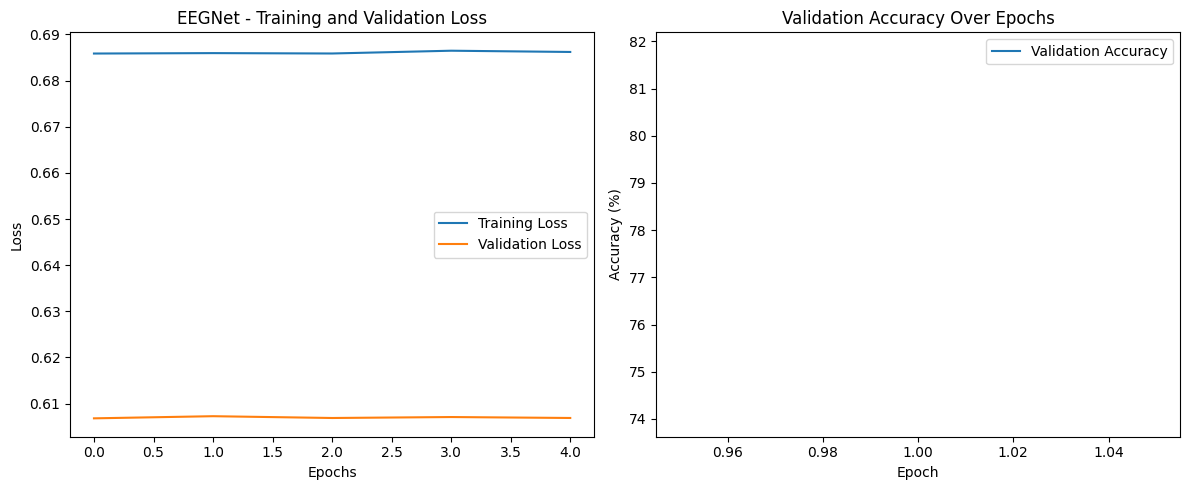

In [41]:
# PLOTTING
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('EEGNet - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies)+1), accuracies, label='Validation Accuracy')  # Adjust accordingly
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Load Turkish data

In [ ]:
# load the dataframe from the pickle file
import pickle
dir = "E:/ChristianMusaeus/Data/Turkish"
with open(f"{dir}/dataframe.pkl", "rb") as f:
    df = pickle.load(f)

# keep these channels only, these are the indexes: 
""" 
Fp1 -> 0
Fp2 -> 33
F3  -> 4
F4  -> 38
C3  -> 12
C4  -> 48
P3  -> 20
P4  -> 55
O1  -> 26
O2  -> 61
F7  -> 6
F8  -> 40
T7  -> 14
T8  -> 50
P7  -> 22
P8  -> 57
Fz  -> 36
Cz  -> 46
Pz  -> 30 

but add 1 to each index, since the first channel is channel_1
"""

df = df[["channel_1", "channel_34", "channel_5", "channel_39", "channel_13", "channel_49", "channel_21", "channel_56", "channel_27", "channel_62", "channel_7", "channel_41", "channel_15", "channel_51", "channel_23", "channel_58", "channel_37", "channel_47", "channel_31", "label"]]

patient_ids = np.repeat([1,2,3,4,5,6,7,8,9,10],76288)  # Make sure to have this aligned with your epochs/labels

# Normalize per patient (within training and test sets)
data = df.drop("label", axis=1).values
data_norm = []
for patient_id in np.unique(patient_ids):
    patient_data = data[patient_ids == patient_id]
    scaler = StandardScaler()
    patient_data_scaled = scaler.fit_transform(patient_data)
    print(f"min and max of patient {patient_id}: {np.min(patient_data_scaled), np.max(patient_data_scaled)}")
    data_norm.append(patient_data_scaled)

data_norm = np.concatenate(data_norm, axis=0)
# add labels back
y = df["label"].values
data = data_norm

# make data a dataframe again
df = pd.DataFrame(data)
print(f"size of df: {df.shape}")

# split the data into epochs of 256 datapoints each
epochs = []
for i in range(0, len(df), 256):
    epochs.append(df.iloc[i:i+256].values)

# convert the list of epochs to a numpy array
epochs = np.array(epochs)
print(f"size of epochs: {epochs.shape}")

# save the SCALED epochs
with open(f"{dir}/scaled_rawEEG_epochs.pkl", "wb") as f:
    pickle.dump(epochs, f)




min and max of patient 1: (np.float64(-2.5061664365916747), np.float64(3.2048110636610154))
min and max of patient 2: (np.float64(-2.2856199344616766), np.float64(3.1704214250154332))
min and max of patient 3: (np.float64(-2.6244058798465795), np.float64(2.326236025125405))
min and max of patient 4: (np.float64(-2.9839669159521462), np.float64(3.0033738566092985))
min and max of patient 5: (np.float64(-2.7180645928577865), np.float64(1.9617189652654394))
min and max of patient 6: (np.float64(-3.8235823428136357), np.float64(1.5538075585523163))
min and max of patient 7: (np.float64(-2.17836904765987), np.float64(2.700097334829556))
min and max of patient 8: (np.float64(-1.9391087092804788), np.float64(4.868952462591622))
min and max of patient 9: (np.float64(-3.278040789072896), np.float64(2.18437991679923))
min and max of patient 10: (np.float64(-1.6112388744411374), np.float64(4.696875071895533))
size of df: (762880, 19)
size of epochs: (2980, 256, 19)


In [ ]:
# open the scaled epochs
import pickle
import pandas as pd
import torch
dir = "E:/ChristianMusaeus/Data/Turkish"

with open(f"{dir}/scaled_rawEEG_epochs.pkl", "rb") as f:
    epochs = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
# convert the numpy array to a tensor and move it to the GPU
epochs = torch.tensor(epochs, dtype=torch.float32).to(device)
print()
# print(torch.rand(2,3).cuda())



device: cuda



In [ ]:
labels = []
for _ in range(10):
    labels.append(np.repeat([1, 0], 149))
labels = np.concatenate(labels)

print(f"size of labels: {labels.shape}")


size of labels: (2980,)
